# Assignment

Feature selection refers to algorithms that can help us narrow down our **feature set** to a smaller set of important features, where importance here refers to the strength of the relationship between the feature and the target. A more important feature is one that ultimately can influence the model's prediction more. In this assignment, you will write a program that imploments filter-based feature selection.

**Filter-based selection** refer to methods we can use to identify pairs of features with a high correlation and remove one of them from the data. One way we can measure the degree to which two features are associated is using **correlation**, but correlation (**pearson's correlation coefficient**, to be specific) measures the strength of **linear association** meaning that when correlation is high between two features (close to 1 or -1) then their scatter plot looks like a straight line. If instead of a straight line the scatter plot followed a curved line, we need to use other measures such as **ranked correlation** or **mutual information**.

In the following example, we generate two features $X$ and $Y$ which are related to each other based on a polynomial (curve-like) equation with some added noise.

Standard Deviation of Y = 1.20


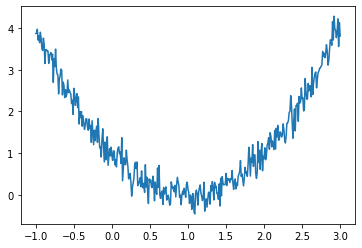

In [10]:
import numpy as np
import pandas as pd

X = np.linspace(start = -1, stop = 3, num = 401, endpoint = True)
Y = X**2 - 2*X + 1 # Y is a polynomial function of X
print("Standard Deviation of Y = {:0.2f}".format(np.std(Y)))

noise_var = 0.2
noise = np.random.normal(0, noise_var, len(X))
Y += noise # add noise

import matplotlib.pyplot as plt
plt.plot(X, Y)
plt.show()

Of course we can can just plot the features against each other and see how they're related, but imagine having to do this for every pair of some 20 features. So instead we want to rely on some metric to do this, so that we can later simply filter out redundant features based on correlation or some other metric. Let's see what the correlation coefficient is.

In [11]:
corr = np.corrcoef(X, Y)[0, 1]
print("Correlation between X and Y is {:0.2f}".format(corr))

Correlation between X and Y is 0.02


As we can see, the correlation is close to zero, and if we had not plotted $X$ against $Y$, we would have been led to believe that there is no association between them, but let's now use mutual information to capture the stregth of their association.

In [12]:
from sklearn.metrics import mutual_info_score

def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency = c_xy)
    return mi

print("Mutual information = {:0.2f}".format(calc_MI(X, Y, 20)))

Mutual information = 1.47


Now that you learned about mutual information, you are going to use it for the purpose of feature selection. Return to the `retail-churn.csv` dataset that we worked with in the previous assignment.

In [13]:
churn = pd.read_csv('data/retail-churn.csv')
churn.dtypes #checking the data types of the columns

UserId             int64
Age               object
Address           object
Column 0           int64
TransactionId      int64
Timestamp         object
ItemId           float64
Quantity           int64
Value              int64
dtype: object

Run the following steps to pre-process the data:

1. Convert `Timestamp` into a `datetime` column and extract two new columns: `DoW` is the day of the week and `Month` is the calendar month. <span style="color:red" float:right>[1 point]</span>

In [14]:
churn['Timestamp']= pd.to_datetime(churn['Timestamp']) # changes timestamp from type object tp Datetime
churn['Month'] = pd.DatetimeIndex(churn['Timestamp']).month # isolates months
churn['DOW'] = pd.DatetimeIndex(churn['Timestamp']).weekday # isolates day of week
churn.head()

,UserId,Age,Address,Column 0,TransactionId,Timestamp,ItemId,Quantity,Value,Month,DOW
0,101981,F,E,2860,818463,2000-11-01,4.710000e+12,1,37,11,2
1,101981,F,E,2861,818464,2000-11-01,4.710000e+12,1,17,11,2
2,101981,F,E,2862,818465,2000-11-01,4.710000e+12,1,23,11,2
3,101981,F,E,2863,818466,2000-11-01,4.710000e+12,1,41,11,2
4,101981,F,E,2864,818467,2000-11-01,4.710000e+12,8,288,11,2


2. One-hot encode `Address`, `DoW` and `Month`. Your pre-processed data should only contain the features created above as well as `Quantity` and `Value`. <span style="color:red" float:right>[1 point]</span>

In [16]:
#creates catagories for a given column
cat_cols = ['Address','DOW','Month']
churn[cat_cols] = churn[cat_cols].astype('category')

# One Hot encodes 'Address', 'DOW','Month'
OH_churn = pd.get_dummies(churn[['Address', 'DOW','Month']], prefix = ['Address', 'DOW','Month'])

# Adds Quantity and Value
OH_churn['Quantity'] = churn['Quantity']
OH_churn['Value'] = churn['Value']

OH_churn.head()

,Address_A,Address_B,Address_C,Address_D,Address_E,Address_F,Address_G,Address_H,DOW_0,DOW_1,...,DOW_3,DOW_4,DOW_5,DOW_6,Month_1,Month_2,Month_11,Month_12,Quantity,Value
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,37
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,17
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,23
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,41
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,8,288


3. Now write a function called `reduce_dimensionality`. The input to the function is the pre-processed data. Here's what your function does:
  - It finds the mutual information between all possibles pairs of features in the data. <span style="color:red" float:right>[1 point]</span>
  - If the mutual information is less than some value `threshold` (make it an argument to the function), then it moves on to the next pair. <span style="color:red" float:right>[1 point]</span>
  - If the mutual information is greater than `thershold`, it drops one of the two features (doesn't matter which) from the data. <span style="color:red" float:right>[1 point]</span>

  So the above function should return the data, but with only a subset of the original features so that no two features share a mutual information higher than `threshold`.

In [18]:
# Funciton to remove Mutual Informaiton above a chosen threshold
def reduce_dimensionality(DataFrame,threshold):
    df = DataFrame.copy() # copys dataframe as to not change original
    
    #loops through all possible combinaitons 
    for column1 in df:
        for column2 in df:
            if(column1 != column2):#checks to make sure column is not tested against itsself
                #Tries to test for Mutual Info and Remove if condition met
                try: 
                    if mutual_info_score(df[column1].values,df[column2].values) > threshold :
                        del df[column2]
                except:
                    pass
    return df #returns edited Data Frame 

4. What should your function return if `threshold` is set to 0? Confirm this by running your function. <span style="color:red" float:right>[1 point]</span>

If the Threshold is chosen to be 0 and the result must be between [0,1] than we know that all columns will be removed except one since they all share mutual Information above the Threshold

In [20]:
reduce_dimensionality(OH_churn,0)

,Address_A
0,0
1,0
2,0
3,0
4,0
...,...
252199,0
252200,0
252201,0
252202,0


5. What should your function return if `threshold` is set to 1? Confirm this by running your function. <span style="color:red" float:right>[1 point]</span>

If the Threshold is chosen to be 1 and the result must be between [0,1] than we know that no columns will be removed since none share mutual Information above the Threshold.

In [117]:
reduce_dimensionality(OH_churn,1)

,Address_A,Address_B,Address_C,Address_D,Address_E,Address_F,Address_G,Address_H,DOW_0,DOW_1,...,DOW_3,DOW_4,DOW_5,DOW_6,Month_1,Month_2,Month_11,Month_12,Quantity,Value
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,37
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,17
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,23
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,41
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,8,288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252199,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,2,138
252200,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,96
252201,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,89
252202,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,108


6. Run your function on the pre-processed data. Use 0.5 for `threshold`. <span style="color:red" float:right>[1 point]</span>

In [21]:
reduce_dimensionality(OH_churn,.5)

,Address_A,Address_B,Address_C,Address_D,Address_E,Address_F,Address_G,Address_H,DOW_0,DOW_1,...,DOW_3,DOW_4,DOW_5,DOW_6,Month_1,Month_2,Month_11,Month_12,Quantity,Value
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,37
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,17
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,23
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,41
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,8,288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252199,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,2,138
252200,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,96
252201,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,89
252202,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,108


7. Modify your function so that you can choose between mutual information and correlation coefficient. <span style="color:red" float:right>[2 point]</span>

In [22]:
# Funciton to remove rows using Mutual Informaiton or Correlation Coefficent above a chosen threshold
def reduce_dimensionality(isMI,DataFrame,threshold):
    df = DataFrame.copy() # copys dataframe as to not change original
    
    #loops through all possible combinaitons 
    for column1 in df:
        for column2 in df:
            if(column1 != column2):#checks to make sure column is not tested against itsself
                #Tries to test for Mutual Info or Correlation Coefficent depending on chosen isMI and Remove if condition met
                try: 
                    if isMI: # Removal for MI
                        if mutual_info_score(df[column1].values,df[column2].values) > threshold :
                            del df[column2]
                    else: # Removal for CC
                        if np.corrcoef(df[column1].values,df[column2].values)[0, 1] > threshold :
                            del df[column2]
                except:
                    pass
    return df #returns edited Data Frame 

8. Run your function on the pre-processed data, using correlation coefficient instead of mutual information this time. Use the same threshold. <span style="color:red" float:right>[2 point]</span>

In [23]:
reduce_dimensionality(False,OH_churn,.5)

,Address_A,Address_B,Address_C,Address_D,Address_E,Address_F,Address_G,Address_H,DOW_0,DOW_1,...,DOW_3,DOW_4,DOW_5,DOW_6,Month_1,Month_2,Month_11,Month_12,Quantity,Value
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,37
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,17
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,23
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,41
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,8,288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252199,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,2,138
252200,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,96
252201,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,89
252202,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,108


9. Which of the two methods drop the most features? <span style="color:red" float:right>[1 point]</span>

We can see that the Mutual Informaiton Call resulted in 252204 rows × 21 columns While the Correlation Coefficent resulted in 252204 rows × 21 columns, therefore for a tolerence of 0.5 there is the same elimination (0 Columns). If we run at a tolerence of 0.0025 we can see that the Mutual Information Removes more than the Correlation Coefficent (6 Vs 8 remaining)

# End of assignment